In [2]:
from default_globals import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from utils import make_nice_plots
from scipy.stats import binom
import glob
make_nice_plots()

# xx = np.linspace(0, 1, 100)
# plt.figure()
# plt.plot(xx, 6 * xx, color='indigo', linewidth=3)
# plt.plot(xx, 5 * xx, color='navy', linewidth=3)
# plt.plot(xx, 4 * xx, color='teal', linewidth=3)
# plt.plot(xx, 3 * xx, color='goldenrod', linewidth=3)
# plt.plot(xx, 2 * xx, color='orangered', linewidth=3)
# plt.plot(xx, 1 * xx, color='crimson', linewidth=3)
# plt.show()



In [3]:
from ligo.skymap.io.fits import read_sky_map
from tqdm import tqdm

SKYMAP_DIR = "/home/lucas/Documents/PhD/skymaps_4/"
COORD_PATH = '/home/lucas/Documents/PhD/true_r_theta_phi_4.txt'

# for filename in tqdm(np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))):

#     skymap = read_sky_map(filename, moc=True)
#     nnans = np.sum(np.isnan(np.array(skymap['PROBDENSITY'])))
#     if nnans > 0:
#         print(nnans)
#         os.system(f'rm -rf {filename}')

# good_skymaps = np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))
# good_labels = [f[-13:-8] for f in good_skymaps]

# filtered_lines = []
# with open(COORD_PATH, 'r') as file:
#     for line in file:
#         columns = line.strip().split(',')

#         first_column_value = columns[0]
#         if first_column_value in good_labels:
#             filtered_lines.append(line)

# with open(COORD_PATH, 'w') as file:
#     file.writelines(filtered_lines)


/home/lucas/Documents/PhD/.venv/lib/python3.13/site-packages/ligo/skymap/io/events/ligolw.py:26: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/lucas/Documents/PhD/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# NEW_NAME = '5'

# # Relabel idx
# for filename in tqdm(np.array(glob.glob(SKYMAP_DIR + 'skymap_0*'))):
#     new_filename = filename[:-13] + NEW_NAME + filename[-12:]
#     os.rename(filename, new_filename)

# renamed_lines = []
# with open(COORD_PATH, 'r') as file:
#     for line in file:
#         columns = line.strip().split(',')
#         new_line = NEW_NAME + str(line)[1:]
#         renamed_lines.append(new_line)
# with open(COORD_PATH, 'w') as file:
#     file.writelines(renamed_lines)

In [5]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]


def get_cdfs(posteriors):
    posteriors -= np.max(posteriors, axis=0)
    pdf = np.exp(posteriors)
    cdfs = np.cumsum(pdf, axis=0)
    cdfs /= np.max(cdfs, axis=0)
    return cdfs


def get_pdfs(posteriors, axis):
    posteriors -= np.max(posteriors, axis=0)
    pdf = np.exp(posteriors)
    norms = simpson(y=pdf, x=axis, axis=0)  # Simpson should be fine...
    pdfs = pdf / norms
    return pdfs


def load_posteriors(path):
    posteriors = np.load(path)
    shape = posteriors.shape
    return posteriors, shape


In [6]:
from utils import uniform_shell_sampler
from redshift_utils import fast_z_at_value
import astropy.units as u

r, t, p = uniform_shell_sampler(COSMO.comoving_distance(1e-4).value, COSMO.comoving_distance(1.5).value, n_samps=80)
r2, t2, p2 = uniform_shell_sampler(COSMO.comoving_distance(1e-4).value, COSMO.comoving_distance(10).value, n_samps=int(1e3))
r_total = np.append(r, r2)
z_total = fast_z_at_value(COSMO.comoving_distance, r_total * u.Mpc)
z2 = fast_z_at_value(COSMO.comoving_distance, r2 * u.Mpc)

print(f'Expected number density within z=1.5: {np.sum(z2 < 1.5) / COSMO.comoving_volume(1.5)}')
print(f'Realized number density within z=1.5: {np.sum(z_total < 1.5) / COSMO.comoving_volume(1.5)}')

print(np.sum(z2 < 1.5))


Expected number density within z=1.5: 2.2879473822178602e-10 1 / Mpc3
Realized number density within z=1.5: 4.4162705284670325e-10 1 / Mpc3
86


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


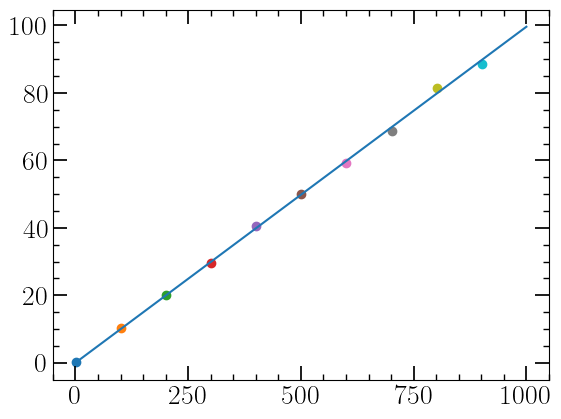

In [7]:
plt.figure()
for nagn in tqdm(np.arange(1, 1e3, 100).astype(int)):
    lowz = np.empty(100)
    for i in range(100):
        r, t, p = uniform_shell_sampler(COSMO.comoving_distance(1e-4).value, COSMO.comoving_distance(10).value, n_samps=nagn)
        z = fast_z_at_value(COSMO.comoving_distance, r * u.Mpc)
        lowz[i] = np.sum(z < 1.5)

    plt.scatter(nagn, np.mean(lowz))
plt.plot(np.linspace(0, 1000, 10), np.linspace(0, 1000, 10) * (COSMO.comoving_distance(1.5).value / COSMO.comoving_distance(10).value)**3)
plt.show()



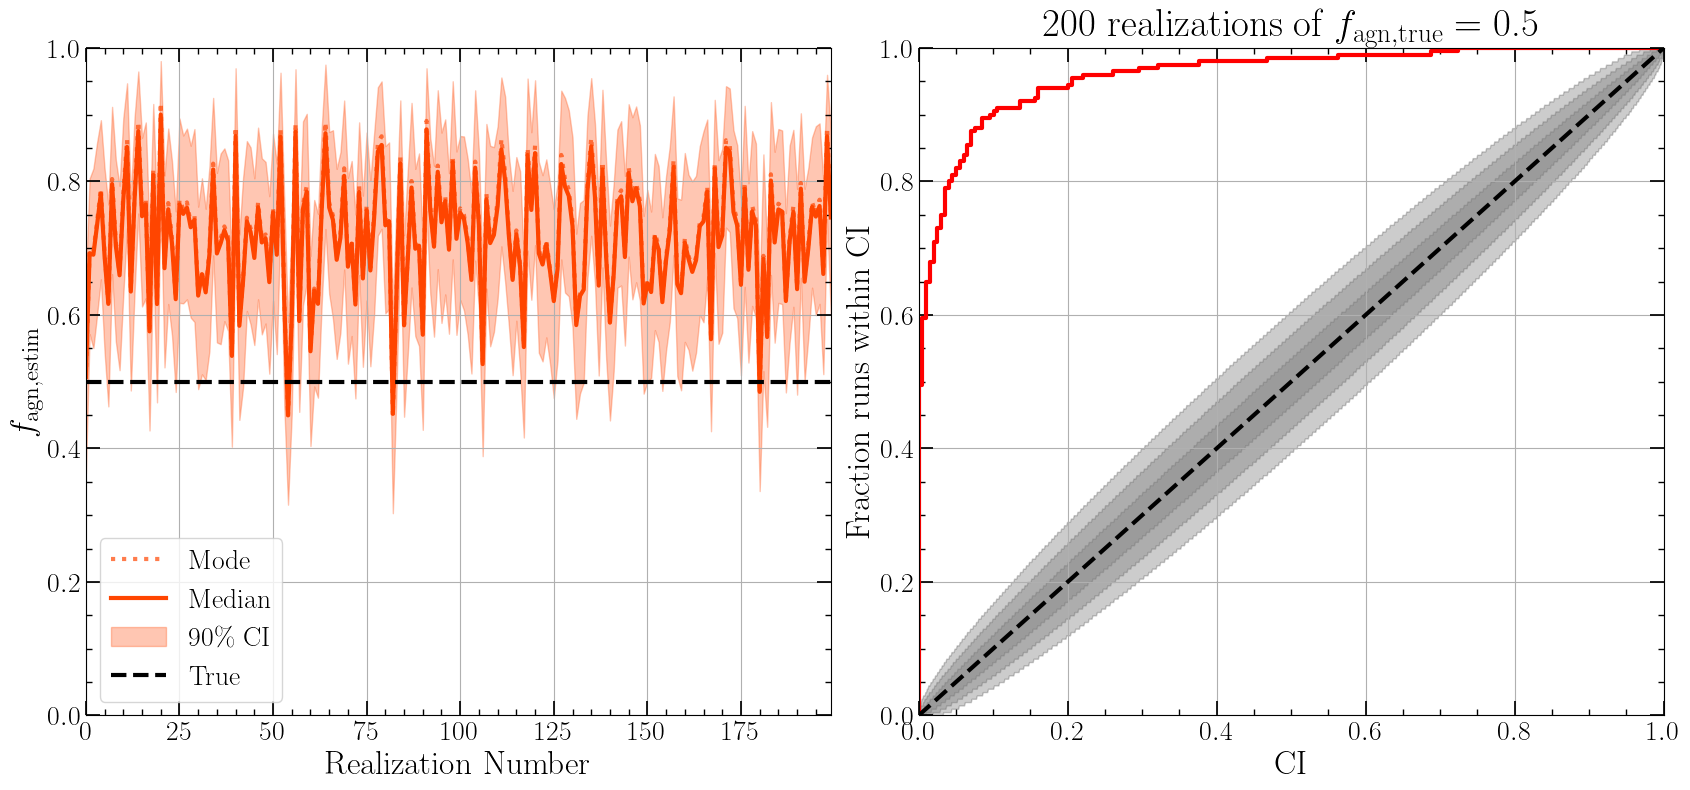

In [8]:
p26_posteriors, posteriors_shape = load_posteriors('/home/lucas/Documents/PhD/darksirenpop/p26_likelihood_posteriors_realdata_False_agnZprior_uniform_comoving_volume_lumthresh_45.5_perfectz_False_galplanemask_True_addAGN_10000_nrealizations_200_batch_96_skymapCL_0.999_agnZerror_quaia_gwZmax_4.npy')
datasets_list = [p26_posteriors]
# LABELS = [0]
FAGN_TRUE = 0.5

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
for idx, posterior in enumerate(datasets_list):
    nx = posterior.shape[1]
    xx = np.arange(nx)  #np.linspace(0, 1, posterior.shape[1])

    cdfs = get_cdfs(posterior)
    
    cdf_at_true_val = np.zeros(nx)
    q005 = np.zeros(nx)
    q050 = np.zeros(nx)
    q095 = np.zeros(nx)
    for i, cdf in enumerate(cdfs.T):
        inverse_cdf = interp1d(cdf, LOG_LLH_X_AX, bounds_error=False, fill_value='extrapolate')
        q005[i] = inverse_cdf(0.05)
        q050[i] = inverse_cdf(0.50)
        q095[i] = inverse_cdf(0.95)

        cdf_at_true_val[i] = interp1d(LOG_LLH_X_AX, cdf)(FAGN_TRUE)

    mode_fagns = LOG_LLH_X_AX[np.argmax(posterior, axis=0)]

    ax1.plot(xx, mode_fagns, color=COLORS[idx], alpha=0.7, linewidth=3, linestyle='dotted', label='Mode')
    ax1.plot(xx, q050, color=COLORS[idx], linewidth=3, label='Median')
    ax1.fill_between(xx, q005, q095, color=COLORS[idx], alpha=0.3, label=r'90$\%$ CI')
ax1.hlines(FAGN_TRUE, 0, nx - 1, linestyle='dashed', color='black', zorder=6, linewidth=3, label='True')
ax1.legend()
ax1.set_xlabel(r'Realization Number')
ax1.set_ylabel(r'$f_{\rm agn, estim}$')
ax1.grid()
ax1.set_xlim(0, nx - 1)
ax1.set_ylim(0, 1)

# plt.figure(figsize=(8,8))

Nrep = len(cdf_at_true_val)
comparisons = np.linspace(0, 1, Nrep)
pp_plot = np.zeros(Nrep)
for i in range(len(pp_plot)):
    pp_plot[i] = np.sum(cdf_at_true_val <= comparisons[i])
pp_plot /= len(cdf_at_true_val)

CI = np.linspace(0, 0.9999, 1000)
for ci, alpha in zip([0.6827, 0.9545, 0.9973], [0.1,0.15,0.2]):
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, Nrep, CI) / Nrep
    upper = binom.ppf(edge_of_bound, Nrep, CI) / Nrep
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

ax2.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
ax2.step(comparisons, pp_plot, linewidth=3, color='red')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_title(str(Nrep) + ' realizations of ' + r'$f_{\rm agn, true} =$ ' + str(FAGN_TRUE))
ax2.set_xlabel('CI')
ax2.set_ylabel('Fraction runs within CI')
plt.tight_layout()
plt.show()


In [9]:
# Missed NS candidate GW200105_162426 in cleaning data, oops

import pandas as pd
import json

SKYMAP_JSON_PATH = '/home/lucas/Documents/PhD/gw_data/real_skymaps.json'
with open(SKYMAP_JSON_PATH, "r") as f:
    gw_path_dict = json.load(f)
gw_keys = list(gw_path_dict.keys())

gwdat = pd.read_csv('/home/lucas/Documents/PhD/gw_data/events.csv')
# print(gwdat.head())

redshift_dict = {}
redshift_list = []
mass_dict = {}
mass_list = []
for key in gw_keys:
    primary_mass = gwdat['mass_1_source'][gwdat['name'] == key].to_numpy()
    primary_mass_lower = gwdat['mass_1_source_lower'][gwdat['name'] == key].to_numpy()
    primary_mass_upper = gwdat['mass_1_source_upper'][gwdat['name'] == key].to_numpy()

    redshift = gwdat['redshift'][gwdat['name'] == key].to_numpy()
    redshift_lower = gwdat['redshift_lower'][gwdat['name'] == key].to_numpy()
    redshift_upper = gwdat['redshift_upper'][gwdat['name'] == key].to_numpy()

    if len(primary_mass) == 0:
        print(f'Could not find key {key}')

        newkey = key.split('_')[0]
        primary_mass_newkey = gwdat['mass_1_source'][gwdat['name'] == newkey].to_numpy()
        primary_mass_newkey_lower = gwdat['mass_1_source_lower'][gwdat['name'] == newkey].to_numpy()
        primary_mass_newkey_upper = gwdat['mass_1_source_upper'][gwdat['name'] == newkey].to_numpy()
        print(f'But {newkey} got: {primary_mass_newkey}+{primary_mass_newkey_upper}-{primary_mass_newkey_lower}')

        redshift_newkey = gwdat['redshift'][gwdat['name'] == newkey].to_numpy()
        redshift_newkey_lower = gwdat['redshift_lower'][gwdat['name'] == newkey].to_numpy()
        redshift_newkey_upper = gwdat['redshift_upper'][gwdat['name'] == newkey].to_numpy()
        print(f'But {newkey} got: {redshift_newkey}+{redshift_newkey_upper}-{redshift_newkey_lower}')
        
        if len(primary_mass_newkey) == 0:
            print('Not found again! Skipping!')
        else:
            mass_dict[key] = np.array([primary_mass_newkey[0], primary_mass_newkey_upper[0], primary_mass_newkey_lower[0]])
            mass_list.append(primary_mass_newkey)

            redshift_dict[key] = np.array([redshift_newkey[0], redshift_newkey_upper[0], redshift_newkey_lower[0]])
            redshift_list.append(redshift_newkey)

    else:
        dat = np.array([primary_mass[0], primary_mass_upper[0], primary_mass_lower[0]])
        mass_dict[key] = dat
        mass_list.append(primary_mass)
        print(key, mass_dict[key])

        dat = np.array([redshift[0], redshift_upper[0], redshift_lower[0]])
        redshift_dict[key] = dat
        redshift_list.append(redshift)
        print(key, redshift_dict[key])
    print()

GW190803_022701 [37.7  9.8 -6.7]
GW190803_022701 [ 0.54  0.22 -0.22]

GW190421_213856 [42.  10.1 -7.4]
GW190421_213856 [ 0.45  0.21 -0.19]

Could not find key GW150914_095045
But GW150914 got: [35.6]+[4.7]-[-3.1]
But GW150914 got: [0.09]+[0.03]-[-0.03]

GW190413_052954 [33.7 10.4 -6.4]
GW190413_052954 [ 0.56  0.25 -0.21]

GW190731_140936 [41.8 12.7 -9.1]
GW190731_140936 [ 0.56  0.31 -0.26]

GW190916_200658 [ 43.8  19.9 -12.6]
GW190916_200658 [ 0.77  0.45 -0.32]

Could not find key GW170818_022509
But GW170818 got: [35.4]+[7.5]-[-4.7]
But GW170818 got: [0.21]+[0.07]-[-0.07]

GW190521_074359 [43.4  5.8 -5.5]
GW190521_074359 [ 0.21  0.1  -0.1 ]

Could not find key GW170823_131358
But GW170823 got: [39.5]+[11.2]-[-6.7]
But GW170823 got: [0.35]+[0.15]-[-0.15]

GW190408_181802 [24.8  5.4 -3.5]
GW190408_181802 [ 0.29  0.07 -0.11]

Could not find key GW151226_033853
But GW151226 got: [13.7]+[8.8]-[-3.2]
But GW151226 got: [0.09]+[0.04]-[-0.04]

Could not find key GW170608_020116
But GW170608 go

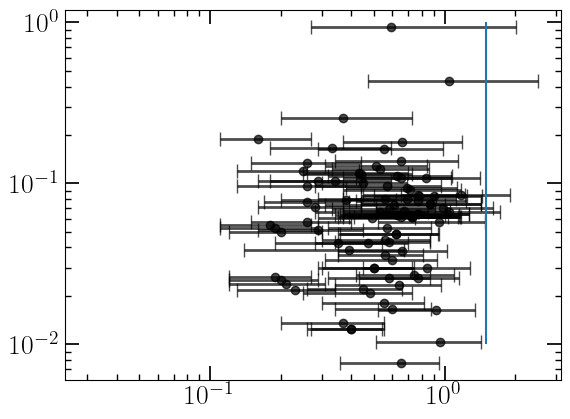

In [10]:
plt.figure()

for i, key in enumerate(redshift_dict.keys()):
    if key == 'GW200105_162426':
        continue
    plt.scatter(redshift_dict[key][0], (redshift_dict[key][2] + redshift_dict[key][1]) / (2 * redshift_dict[key][0]), alpha=0.7, color='black')
    plt.errorbar(redshift_dict[key][0], 
                 (redshift_dict[key][2] + redshift_dict[key][1]) / (2 * redshift_dict[key][0]),
                 xerr=np.array([ [abs(redshift_dict[key][2])], [redshift_dict[key][1]]] ),
                 color='black', 
                 zorder=-1,
                 elinewidth=2,
                 capsize=5,
                 alpha=0.7)
plt.loglog()
plt.vlines(1.5, 0.01, 1)
plt.show()


In [11]:
# os.environ["OMP_NUM_THREADS"] = "1"

# # for gwkey in gw_keys:  
# #     os.system(f'ligo-skymap-stats {gw_path_dict[gwkey]} -p 0.9 0.999 --cosmology --output {"/home/lucas/Documents/PhD/" + gwkey + ".dat"}')
# #     sys.exit(1)

# already_done_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_incat_dict_MOCK.npy', allow_pickle=True).item()
# for mockgw in glob.glob('/home/lucas/Documents/PhD/skymaps_all/*.fits.gz'):
#     gw_id = mockgw[-13:-8]
#     if gw_id in already_done_dict.keys():
#         continue
#     print(gw_id)
#     os.system(f'ligo-skymap-stats {mockgw} -p 0.9 0.999 --cosmology --output {"/home/lucas/Documents/PhD/mockstats/gw_" + gw_id + ".dat"}')
#     # sys.exit(1)


GW190803_022701
GW190421_213856
GW190413_052954
GW190731_140936
GW190916_200658
GW170823_131358
GW190519_153544
GW190805_211137
GW190413_134308
GW190602_175927
GW190706_222641
GW190701_203306
GW190910_112807
GW190426_190642
GW190719_215514
GW190514_065416
GW190915_235702
GW190620_030421
GW190929_012149
GW190403_051519
GW190727_060333
GW190513_205428
GW190527_092055
GW170729_185629
GW190503_185404
GW190517_055101
GW190521_030229
GW190828_063405
GW190926_050336
GW200311_115853
GW200308_173609
GW200209_085452
GW191126_115259
GW191215_223052
GW191204_110529
GW200208_130117
GW200220_061928
GW200224_222234
GW200128_022011
GW200216_220804
GW191113_071753
GW200219_094415
GW200322_091133
GW191127_050227
GW191222_033537
GW200306_093714
GW200208_222617
GW191230_180458
GW191109_010717
GW200220_124850
GW230601_224134
GW230606_004305
GW230608_205047
GW230609_064958
GW230624_113103
GW230628_231200
GW230630_125806
GW230702_185453
GW230704_021211
GW230704_212616
GW230706_104333
GW230707_124047
GW230708

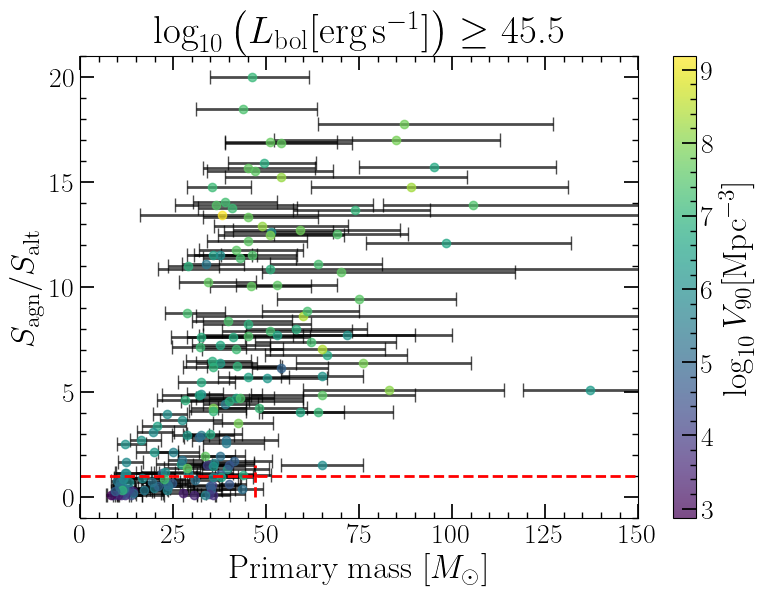

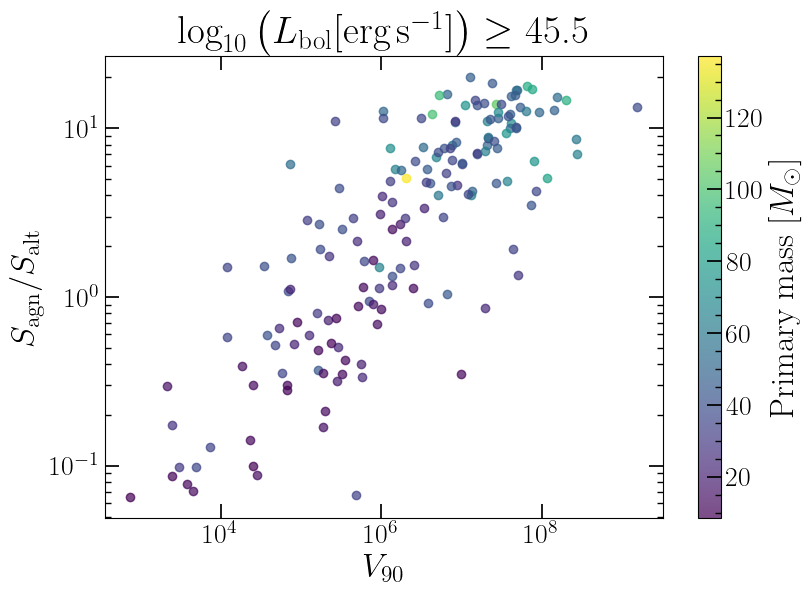

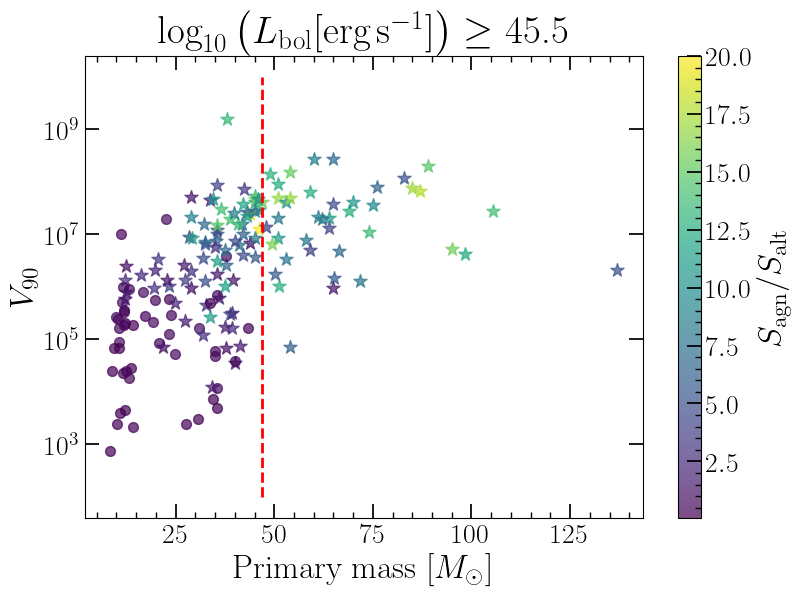

In [ ]:
thresh = '45.5'
agnZprior = '45.5'
perfz = False
realdata = True
galmask = True
skycl = 0.999
zmax = 7


def evidence(sagn_incat, sagn_outcat, salt, correction=3.4597):
    return (sagn_incat + sagn_outcat) / salt * correction


try:
    s_agn_incat_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_incat_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{zmax}.npy', allow_pickle=True).item()
    s_agn_outofcat_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_outofcat_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{zmax}.npy', allow_pickle=True).item()
except:
    s_agn_incat_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_cw_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{zmax}.npy', allow_pickle=True).item()
    s_agn_outofcat_dict = np.load(f'/home/lucas/Documents/PhD/s_alt_cw_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{zmax}.npy', allow_pickle=True).item()
s_alt_dict = np.load(f'/home/lucas/Documents/PhD/s_alt_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{zmax}.npy', allow_pickle=True).item()


v90_dict = {}
v90_list = []
for key in gw_keys:
    d = np.genfromtxt(f'/home/lucas/Documents/PhD/gw_data/skymap_stats/{key}.dat')
    v90_list.append(d[1][-2])
    v90_dict[key] = d[1][-2]

minmass = min(mass_list)
maxmass = max(mass_list)
v90min = min(v90_list)
v90max = max(v90_list)

evidence_list = []
for i, key in enumerate(s_agn_incat_dict.keys()):
    evidence_current = evidence(s_agn_incat_dict[key], s_agn_outofcat_dict[key], s_alt_dict[key])  #s_agn_incat_dict[key] / s_agn_outofcat_dict[key]
    evidence_list.append(evidence_current)
    if evidence_current > 1:
        print(key)
evidencemin = min(evidence_list)
evidencemax = max(evidence_list)


plt.figure(figsize=(9,6))
for i, key in enumerate(s_agn_incat_dict.keys()):
    if key == 'GW200105_162426':
        continue
    plt.scatter(mass_dict[key][0], evidence(s_agn_incat_dict[key], s_agn_outofcat_dict[key], s_alt_dict[key]), c=np.log10(v90_dict[key]), alpha=0.7, vmin=np.log10(v90min), vmax=np.log10(v90max))
    plt.errorbar(mass_dict[key][0], 
                 evidence(s_agn_incat_dict[key], s_agn_outofcat_dict[key], s_alt_dict[key]), 
                 xerr=np.array([ [abs(mass_dict[key][2])], [mass_dict[key][1]]] ), 
                 color='black', 
                 zorder=-1,
                 elinewidth=2,
                 capsize=5,
                 alpha=0.7)
plt.hlines(1, 0, 250, linestyles='dashed', color='red', linewidth=2)
plt.vlines(47, 0, 1.5, linestyles='dashed', color='red', linewidth=2)
clb = plt.colorbar()
clb.set_label(r'$\log_{10} V_{90} [\mathrm{Mpc^ {-3}}]$')
plt.xlim(0, 150)
# plt.ylim(0, 1.5)
# plt.semilogy()
plt.xlabel(r'Primary mass [$M_{\odot}$]')
plt.ylabel(r'$S_{\rm agn} / S_{\rm alt}$')
plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {thresh}')
plt.show()


plt.figure(figsize=(9,6))
for i, key in enumerate(s_agn_incat_dict.keys()):
    if key == 'GW200105_162426':
        continue
    plt.scatter(v90_dict[key], evidence(s_agn_incat_dict[key], s_agn_outofcat_dict[key], s_alt_dict[key]), c=mass_dict[key][0], alpha=0.7, vmin=minmass, vmax=maxmass)
plt.loglog()
# plt.semilogx()
plt.xlabel(r'$V_{90}$')
plt.ylabel(r'$S_{\rm agn} / S_{\rm alt}$')
clb = plt.colorbar()
clb.set_label(r'Primary mass [$M_{\odot}$]')
plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {thresh}')
plt.show()


plt.figure(figsize=(9,6))
for i, key in enumerate(s_agn_incat_dict.keys()):
    if key == 'GW200105_162426':
        continue
    evidence_current = evidence(s_agn_incat_dict[key], s_agn_outofcat_dict[key], s_alt_dict[key])
    if evidence_current > 1:
        marker = '*'
        s = 100
    else:
        marker = 'o'
        s = 50
    plt.scatter(mass_dict[key][0], v90_dict[key], c=evidence_current, alpha=0.7, vmin=evidencemin, vmax=evidencemax, marker=marker, s=s)
plt.vlines(47, 1e2, 1e10, linestyles='dashed', color='red', linewidth=2)
plt.semilogy()
plt.ylabel(r'$V_{90}$')
plt.xlabel(r'Primary mass [$M_{\odot}$]')
clb = plt.colorbar()
clb.set_label(r'$S_{\rm agn} / S_{\rm alt}$')
plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {thresh}')
plt.show()


In [13]:
import astropy.units as u
fast_z_at_value(COSMO.luminosity_distance, 13.3 * u.Gpc)

np.float64(1.7258904141870008)

In [14]:
# Comparison with mock data

# # TODO: check correlation with distmean, which is idx 2 in .dat files

# # s_agn_incat_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_agn_incat_dict_MOCK_complete.npy', allow_pickle=True).item()
# # s_agn_outofcat_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_agn_outofcat_dict_MOCK_complete.npy', allow_pickle=True).item()
# # s_alt_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_alt_dict_MOCK_complete.npy', allow_pickle=True).item()
# # fromagn_dict_mock = np.load(f'/home/lucas/Documents/PhD/from_agn_dict_MOCK_complete.npy', allow_pickle=True).item()

# s_agn_incat_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_agn_incat_dict_p26_likelihood_posteriors_realdata_False_lumthresh_45.5_perfectz_False_galplanemask_True_addAGN_10000_nrealizations_1_batch_19606_skymapCL_0.999.npy', allow_pickle=True).item()
# s_agn_outofcat_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_agn_outofcat_dict_p26_likelihood_posteriors_realdata_False_lumthresh_45.5_perfectz_False_galplanemask_True_addAGN_10000_nrealizations_1_batch_19606_skymapCL_0.999.npy', allow_pickle=True).item()
# s_alt_dict_mock = np.load(f'/home/lucas/Documents/PhD/s_alt_dict_p26_likelihood_posteriors_realdata_False_lumthresh_45.5_perfectz_False_galplanemask_True_addAGN_10000_nrealizations_1_batch_19606_skymapCL_0.999.npy', allow_pickle=True).item()
# fromagn_dict_mock = np.load(f'/home/lucas/Documents/PhD/from_agn_dict_p26_likelihood_posteriors_realdata_False_lumthresh_45.5_perfectz_False_galplanemask_True_addAGN_10000_nrealizations_1_batch_19606_skymapCL_0.999.npy', allow_pickle=True).item()

# v90_dict_mock = {}
# v90_list_mock = []
# color_list_mock = []
# for key in s_agn_incat_dict_mock.keys():
#     try:
#         d = np.genfromtxt(f'/home/lucas/Documents/PhD/mockstats/gw_{key}.dat')
#         v90_list_mock.append(d[1][-2])
#         v90_dict_mock[key] = d[1][-2]

#         fromagn = fromagn_dict_mock[key]
#         if fromagn:
#             color_list_mock.append('blue')
#         else:
#             color_list_mock.append('red')
#     except:
#         print(key)
#         continue
# v90s_mock = np.array(v90_list_mock)

# ratios = []
# for i, key in enumerate(s_agn_incat_dict_mock.keys()):
#     try:
#         ratios.append(s_agn_incat_dict_mock[key] / s_agn_outofcat_dict_mock[key])
#         if (s_alt_dict_mock[key] == 0):
#             print('Got Salt zero:', key, s_agn_incat_dict_mock[key], s_agn_outofcat_dict_mock[key], s_alt_dict_mock[key])
#     except:
#         print(key)
#         continue
    
# ratios = np.array(ratios)

# plt.figure(figsize=(9,6))
# selec = (ratios > 1e-2) #& (v90s_mock > 1e2)
# plt.scatter(v90s_mock[selec], ratios[selec], alpha=0.05, c=np.array(color_list_mock)[selec])

# for i, key in enumerate(s_agn_incat_dict.keys()):
#     if key == 'GW200105_162426':
#         continue
#     plt.scatter(v90_dict[key], s_agn_incat_dict[key] / s_agn_outofcat_dict[key], c=mass_dict[key][0], alpha=0.7, vmin=minmass, vmax=maxmass)
# plt.colorbar(label=r'$M_{\bullet}/M_{\odot}$')
# plt.loglog()
# plt.xlabel(r'$V_{90}$')
# plt.ylabel(r'$S_{\rm agn, cw} / S_{\rm alt, cw}$')
# plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {thresh}')

# from matplotlib.lines import Line2D
# blue_dot = Line2D([0], [0], marker='o', color='w', label='From AGN',
#                   markerfacecolor='blue', markersize=10)
# red_dot = Line2D([0], [0], marker='o', color='w', label='From ALT',
#                  markerfacecolor='red', markersize=10)
# plt.legend(handles=[blue_dot, red_dot], loc='best')
# plt.show()


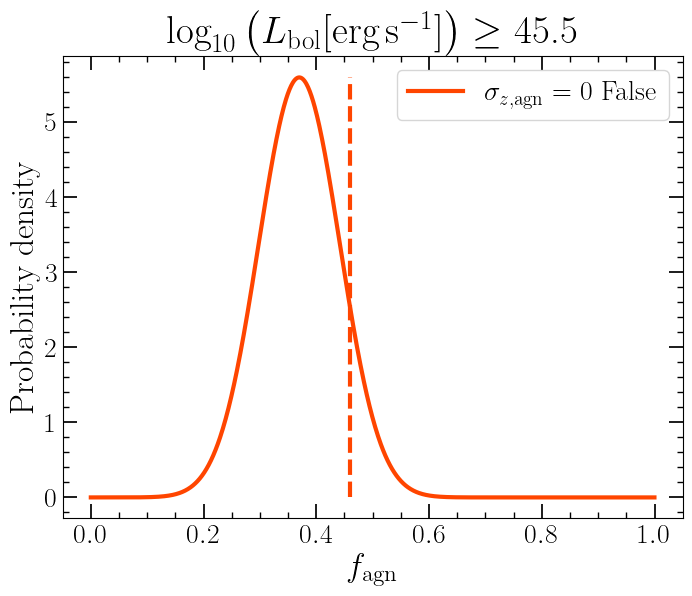

In [15]:
# f_agn posterior

thresh = '45.5'
agnZprior = '45.5'
perfz = False
realdata = True
galmask = True
skycl = 0.999
gwzmax = 7

log_llh = np.zeros((len(LOG_LLH_X_AX), 1))
plt.figure(figsize=(8,6))
for i, perfz in enumerate([False]):  #True, 
    S_agn_incat_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_incat_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{gwzmax}.npy', allow_pickle=True).item()
    S_agn_outofcat_dict = np.load(f'/home/lucas/Documents/PhD/s_agn_outofcat_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{gwzmax}.npy', allow_pickle=True).item()
    S_alt_dict = np.load(f'/home/lucas/Documents/PhD/s_alt_dict_p26_likelihood_posteriors_realdata_{realdata}_agnZprior_{agnZprior}_lumthresh_{thresh}_perfectz_{perfz}_galplanemask_{galmask}_skymapCL_{skycl}_gwZmax_{gwzmax}.npy', allow_pickle=True).item()

    S_agn_incat = np.array([S_agn_incat_dict[key] for key in gw_keys])
    S_agn_outofcat = np.array([S_agn_outofcat_dict[key] for key in gw_keys])
    S_alt = np.array([S_alt_dict[key] for key in gw_keys])

    loglike = np.log(skycl * LOG_LLH_X_AX[None,:] * (S_agn_incat[:,None] + S_agn_outofcat[:,None] - S_alt[:,None]) + S_alt[:,None])
    log_llh[:,0] = np.sum(loglike, axis=0)  # Sum over all GWs
    posterior = log_llh

    posterior -= np.max(posterior)
    pdf = np.exp(posterior)
    norm = simpson(y=pdf, x=LOG_LLH_X_AX, axis=0)  # Simpson should be fine...
    pdf = pdf / norm

    plt.plot(LOG_LLH_X_AX, pdf, label=r'$\sigma_{z, \rm agn} = 0$' + f' {perfz}', linewidth=3, color=COLORS[i])

    cdf = get_cdfs(posterior)[:,0]
    inverse_cdf = interp1d(cdf, LOG_LLH_X_AX, bounds_error=False, fill_value='extrapolate')
    q090 = inverse_cdf(0.90)

    plt.vlines(q090, 0, np.max(pdf), color=COLORS[i], linewidth=3, linestyle='dashed')

plt.legend()
plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {thresh}')
plt.xlabel(r'$f_{\rm agn}$')
plt.ylabel('Probability density')
plt.show()
